# 一、特征工程目标

对于特征进一步分析，并对数据进行处理。

完成对于特征工程的分析，并对数据进行一些图表或者文字总结并打卡。

# 二、内容介绍

常见的特征工程包括：

1. 异常处理：
    - 通过箱线图（或 3-Sigma）分析删除异常值；
    - BOX-COX 转换（处理有偏分布）；
    - 长尾截断；
2. 特征归一化/标准化：
    - 标准化（转换为标准正态分布）；
    - 归一化（抓换到[0, 1]区间）；
    - 针对幂律分布，可以采用公式： $log({1 + x \over 1 + median})$；
3. 数据分桶：
    - 等频分桶；
    - 等距分桶；
    - Best-KS 分桶（类似利用基尼指数进行二分类）；
    - 卡方分桶；
4. 缺失值处理：
    - 不处理（针对类似 XGBoost等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日、双休日等；
    - 地理信息，包括分箱、分布编码等方法；
    - 非线性变换，包括 log/平方/根号 等；
    - 特征组合，特征交叉；
    - <仁者见仁，智者见智>；
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择法/相关系数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper）；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
    - PCA/LDA/ICA；
    - 特征选择也是一种降维；

# 三、代码示例

## 导入数据

In [140]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 设置pandas显示选项，显示所有列
pd.set_option('display.max_columns', None)     # 显示所有列，不省略
pd.set_option('display.width', None)           # 自动调整显示宽度
pd.set_option('display.max_colwidth', 50)      # 每列内容最多显示50个字符

def get_project_path(*paths):
    """获取项目路径的统一方法"""
    try:
        return os.path.join(os.path.dirname(__file__), *paths)
    except NameError:
        return os.path.join(os.getcwd(), *paths)

In [141]:
## 1) 载入训练集和测试集
Train_data = pd.read_csv(get_project_path('data', 'used_car_train_20200313.csv'), sep=' ')
Test_data = pd.read_csv(get_project_path('data', 'used_car_testB_20200421.csv'), sep=' ')

print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


In [142]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [143]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [144]:
Test_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

## 删除异常值

In [145]:
# 这里我包装了一个异常值处理的代码，可以随便调用
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    @param data 接收 pandas 数据格式
    @param col_name pandas 列名
    @param scale 尺度
    @return
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        @param data_ser 接收 pandas.Series 数据格式
        @param box_scale 箱线图尺寸
        @return
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = data_ser < val_low
        rule_up = data_ser > val_up

        return (rule_low, rule_up), (val_low, val_up)
    
    data_n = data.copy()
    print('data length: ', len(data), 'data_n length: ', len(data_n))
    data_series = data_n[col_name]
    print(f'{col_name} rows: ', len(data_series))
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print('rule', rule, 'value', value)
    print('Delete number is: {}'.format(len(index)))
    
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print('Now column number is: {}'.format(data_n.shape[0]))
    
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print('index_low: ', index_low ,'outliers: ', outliers)
    print('Description of data less than the lower bound is:')
    print(pd.Series(outliers).describe())
    
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print('index_up: ', index_up ,'outliers: ', outliers)
    print('Description of data larger than the upper bound is:')
    print(pd.Series(outliers).describe())

    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])

    return data_n

data length:  150000 data_n length:  150000
power rows:  150000
rule (0         False
1         False
2         False
3         False
4         False
          ...  
149995    False
149996    False
149997    False
149998    False
149999    False
Name: power, Length: 150000, dtype: bool, 0         False
1         False
2         False
3         False
4         False
          ...  
149995    False
149996    False
149997    False
149998    False
149999    False
Name: power, Length: 150000, dtype: bool) value (np.float64(-150.0), np.float64(375.0))
Delete number is: 963
Now column number is: 149037
index_low:  [] outliers:  Series([], Name: power, dtype: int64)
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
index_up:  [    77    171    221    534    632    751    882    919   1080   1283
   1331   1337   1437   2002   2088   2187   2526   2671   2917   316

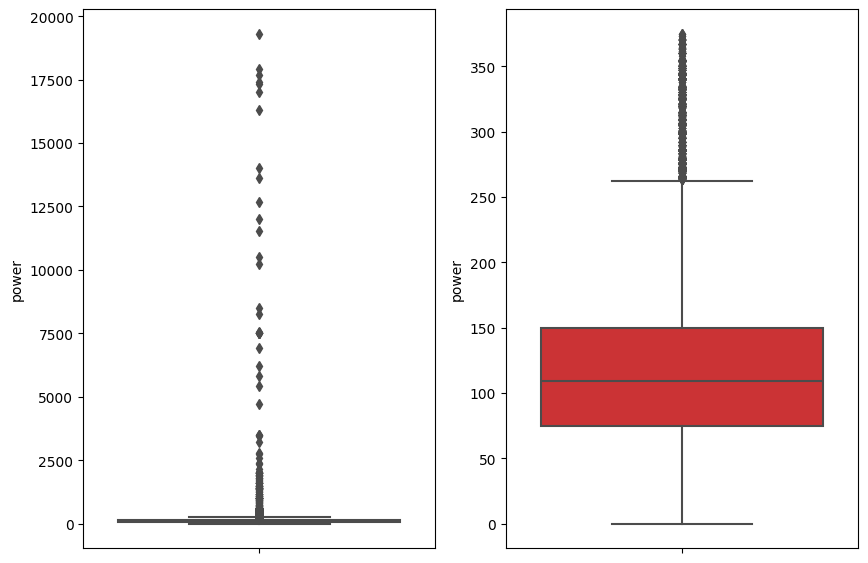

In [146]:
# 我们可以删掉一些异常数据，以 power 为例
# 这里删不删同学可以自行判断
# 但是要注意 test 的数据不能删 == 不能掩耳盗铃是不是

Train_data = outliers_proc(Train_data, 'power', scale=3)

## 特征构造

In [147]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train'] = 1
Test_data['train'] = 0
data = pd.concat([Train_data, Test_data], ignore_index=True)

In [148]:
# 使用时间：data['creatDate'] - data['regDate']，反映汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [149]:
# 看一下空数据，有 15k 个样本的时间是有问题的，我们可以选择删除，也可以选择放着。
# 这里不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 我们可以先放着，因为如果我们 XGBoost 之类的决策树，其本身就能处理缺失值，所以可以不用管。
data['used_time'].isnull().sum()

np.int64(15054)

In [150]:
# 从邮编中提取城市信息，相当于加入了先验知识
# 四级六位编码制，前两位表示省（直辖市、自治区），第三位代表邮区，第四位代表县（市），最后两位为投递区位置。
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])
data = data

In [151]:
data['city']

0         1
1         4
2         2
3          
4         6
         ..
199032    5
199033    5
199034    3
199035     
199036    4
Name: city, Length: 199037, dtype: object

In [152]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby('brand')
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info

brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={'index': 'brand'})
data = data.merge(brand_fe, how='left', on='brand')

In [153]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了
# 为什么要做数据分桶呢？原因有很多
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展
# 2. 离散后的特征对异常值更具鲁棒性，如 age > 30 为 1，否则为 0。对于年龄为 200 的也不会对模型造成很大的干扰
# 3. LR 属于广义线性模型，表达能力有限。经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加入拟合
# 4. 离散后特征可以进行特征交叉，提升表单能力，由 M + N 个变量编程 M * N 个变量，进一步引入非线性，提升了表达能力
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性
bin = [i * 10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [154]:
# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [155]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [156]:
# 目前的数据其实已经可以给树模型使用了，所以我们导出一下
data.to_csv(get_project_path('user_data', 'data_for_tree.csv'), index=False)

<Axes: ylabel='Frequency'>

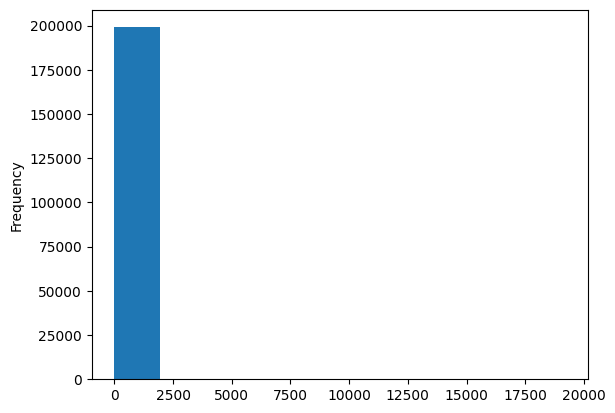

In [157]:
# 我们可以再构造一份特征给 LR NN 之类的模型用
# 之所以分开构造是因为不同模型对数据集的要求不同
# 我们看下数据分布：
data['power'].plot.hist()

<Axes: ylabel='Frequency'>

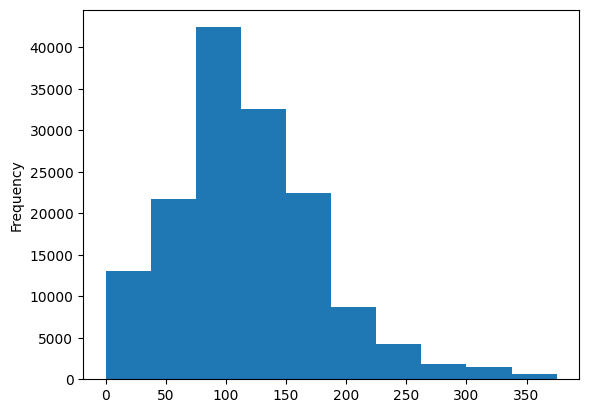

In [158]:
# 我们刚刚已经对 train 进行异常值处理了，但是现在还有这么奇怪的分布是因为 test 中的 power 异常值
# 所以我们其实刚刚 train 中的 power 异常值不删为好，可以用长尾分布截断来代替
Train_data['power'].plot.hist()

In [159]:
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

<Axes: ylabel='Frequency'>

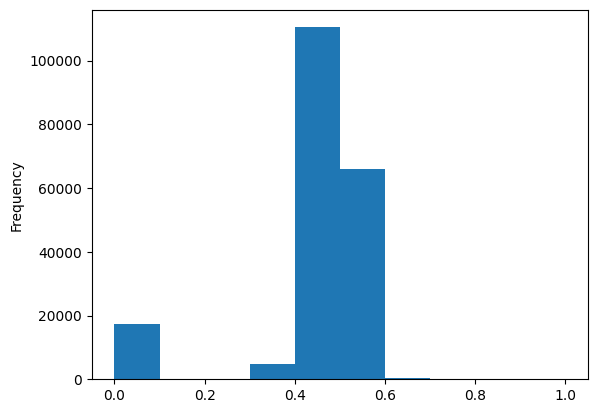

In [160]:
# 我们对其取 log，再做归一化
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1)
data['power'] = max_min(data['power'])
data['power'].plot.hist()

<Axes: ylabel='Frequency'>

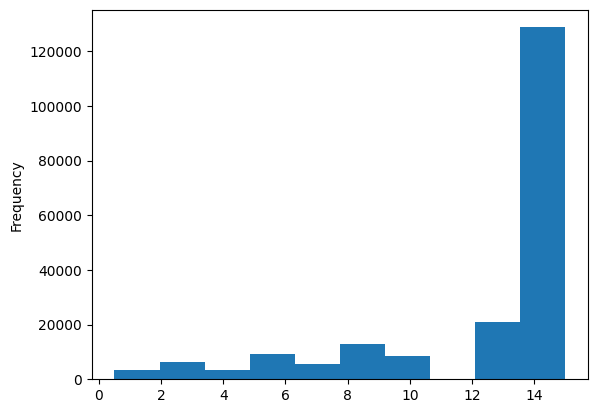

In [161]:
# km 的比较正常，应该是已经做过分桶了
data['kilometer'].plot.hist()

<Axes: ylabel='Frequency'>

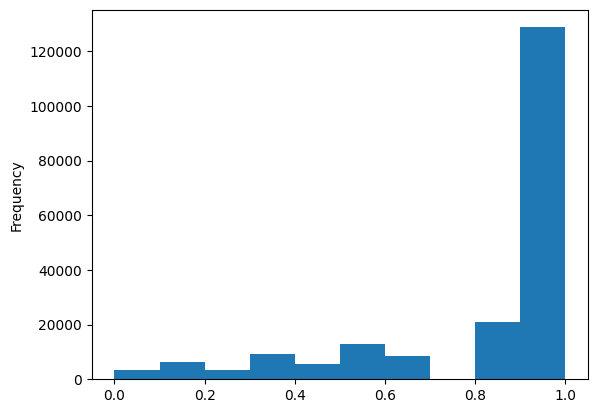

In [162]:
# 所以我们可以直接做归一化
data['kilometer'] = max_min(data['kilometer'])
data['kilometer'].plot.hist()

In [163]:
# 除此之外，还有我们刚刚构造的统计量特征：
# 'brand_amount', 'brand_price_average', 'brand_price_max',
# 'brand_price_median', 'brand_price_min', 'brand_price_std',
# 'brand_price_sum'
# 这里不再一一举例分析了，直接做变换

data['brand_amount'] = max_min(data['brand_amount'])
data['brand_price_average'] = max_min(data['brand_price_average'])
data['brand_price_max'] = max_min(data['brand_price_max'])
data['brand_price_median'] = max_min(data['brand_price_median'])
data['brand_price_min'] = max_min(data['brand_price_min'])
data['brand_price_std'] = max_min(data['brand_price_std'])
data['brand_price_sum'] = max_min(data['brand_price_sum'])

In [164]:
# 对类别特征进行 OneEncoder
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'power_bin'])

In [165]:
print(data.shape)
data.columns

(199037, 370)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

In [166]:
# 这份数据可以给 LR 用
data.to_csv(get_project_path('user_data', 'data_for_lr.csv'), index=False)

## 特征筛选

### 1) 过滤式

In [167]:
# 相关性分析
print(data['power'].corr(pd.Series(data['price']), method='spearman'))
print(data['kilometer'].corr(pd.Series(data['price']), method='spearman'))
print(data['brand_amount'].corr(pd.Series(data['price']), method='spearman'))
print(data['brand_price_average'].corr(pd.Series(data['price']), method='spearman'))
print(data['brand_price_max'].corr(pd.Series(data['price']), method='spearman'))
print(data['brand_price_median'].corr(pd.Series(data['price']), method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


<Axes: title={'center': 'Correlation of Numeric Features with Price'}>

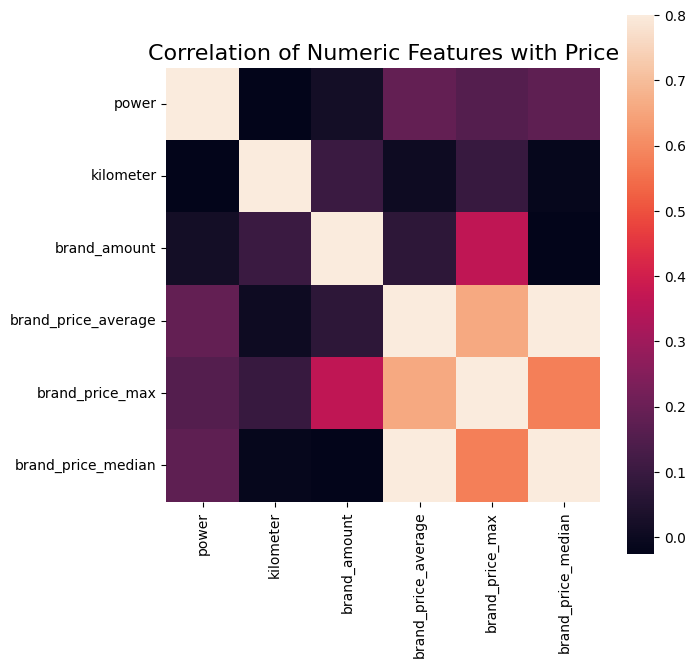

In [168]:
# 当然也可以直接看图
data_numeric = data[['power', 'kilometer', 'brand_amount', 'brand_price_average', 'brand_price_max', 'brand_price_median']]
correlation = data_numeric.corr()

f, ax = plt.subplots(figsize=(7, 7))
plt.title('Correlation of Numeric Features with Price', y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8)

### 2) 包裹式

In [169]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

sfs = SFS(
    LinearRegression(),
    k_features=10,
    forward=True,
    floating=False,
    scoring='r2',
    cv=0
)
# 模型训练只能使用训练集（因为使用了 price）
x = Train_data.drop(['price'], axis=1)

# 将所有 '-' 字符串替换为 NaN，然后填充为 0
# x = x.replace('-', np.nan)
x = x.fillna(0)

# 确保所有列都是数值类型
for col in x.columns:
    if x[col].dtype == 'object':
        x[col] = pd.to_numeric(x[col], errors='coerce')

x = x.fillna(0)
y = Train_data['price']
sfs.fit(x, y)
sfs.k_feature_names_

('bodyType',
 'power',
 'kilometer',
 'v_1',
 'v_3',
 'v_4',
 'v_6',
 'v_9',
 'v_13',
 'v_14')

/Users/lihaizhong/Documents/Project/build-your-own-x/build-your-own-ai/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lihaizhong/Documents/Project/build-your-own-x/build-your-own-ai/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


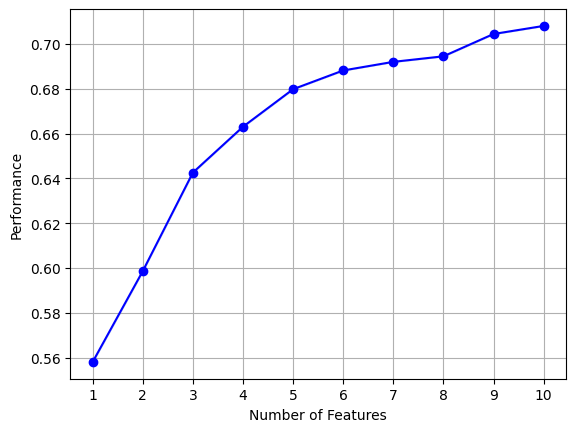

In [170]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

### 3) 嵌入式

In [171]:
# 下一章节介绍 Lasso 回归和决策树可以完成嵌入式特征选择
# 大部分情况下都是用嵌入式做特征筛选

# 四、经验总结

特征工程是比赛中至关重要的一块。特别在传统的比赛，大家的模型选择可能都差不多，调参带来的效果增幅是非常有限的，但特征工程的好坏往往会决定最终的排名和成绩。

特征工程的主要目的还是在于将数据转换为能更好地表示潜在问题的特征，从而提高机器学习的性能。比如，异常值处理是为了去除噪音，填补缺失值可以加入先验知识等。

特征构造也属于特征工程的一部分，其目的是为了增强数据的表达。

有些比赛的特征是匿名特征，这导致我们并不清楚特征相互之间的关联性，这是我们就只有单纯基于特征进行处理，比如装箱、groupby、agg 等这样一些操作进行特征统计。此外，还可以对特征进行进一步的 log、exp 等变换，或者对多个特征进行四则运算（如上面我们算出的使用时长），多项式组合等，然后进行筛选。由于特征的匿名性其实限制了很多对特征的处理，当然有时候用 NN 去提取一些特征也会达到意想不到的良好效果。

对于知道特征含义（非匿名）的特征工程，特别是在工业类型比赛中，会基于信号处理、频域提取、丰度、偏度等构建更为有实际意义的特征，这就是结合背景的特征构建，在推荐系统中也是这样的，各种类型点击率统计，各时段统计，加用户属性的统计等等。这样一种特征构建往往要深入分析背后的业务逻辑或者说物理原理，从而才能更好地找到 magic。

当然特征工程其实是和模型结合在一起的，这就是为什么要为 LR NN 做分桶和特征归一化的原因，而对于特征的处理效果和特征重要性等往往要通过模型来验证。

总的来说，特征工程是一个入门简单，但想精通非常难的事情。